In [1]:
# 2) clone Tuan's resyslab (always required whenever starting a session in kaggle)
import os
if not os.path.exists('/kaggle/working/resyslab_utils'):
    !git clone https://github.com/Azure2212/resyslab_utils.git
%run /kaggle/working/resyslab_utils/resyslab_utils/clouds/cloud_setup.py

Cloning into 'resyslab_utils'...
remote: Enumerating objects: 151, done.
remote: Counting objects: 100% (151/151), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 151 (delta 55), reused 130 (delta 38), pack-reused 0 (from 0)
Receiving objects: 100% (151/151), 30.63 KiB | 4.38 MiB/s, done.
Resolving deltas: 100% (55/55), done.
---------------Tuan's resyslab library started!---------------


In [2]:
# 3) set authority right to push to github by using ssh
setup_github_config(private_key_path = '/kaggle/input/bayesnetworkcl/cogload_BN')

> Setup ssh github...
Key name: cogload_BN
Copy: /kaggle/input/bayesnetworkcl/cogload_BN --> ~/.ssh/cogload_BN
setup github_config finished


In [3]:
# 4) pull code from github into kaggle using ssh private key setted up in previous step
clone_project_from_github(giturl = 'git@github.com:TyTy7023/CogLoad_BayesNetwork.git',
                          folder = '/kaggle/working/cogload', branch = 'combine_Model')

Cloning into '/kaggle/working/cogload'...
remote: Enumerating objects: 871, done.
remote: Counting objects: 100% (217/217), done.
remote: Compressing objects: 100% (167/167), done.
remote: Total 871 (delta 107), reused 136 (delta 48), pack-reused 654 (from 1)
Receiving objects: 100% (871/871), 6.22 MiB | 4.52 MiB/s, done.
Resolving deltas: 100% (477/477), done.


In [4]:
cd /kaggle/working/cogload

/kaggle/working/cogload


                                                            --models_mul 'MLP_Sklearn' 'MLP_Keras' 'E7GB'  'ESVM' 'WGLR'
                                                            --models_single 'SVM' 'XGB' 'LR' 'RF' \
                                                            --models_network 'CNN' 'RNN'

%run -i /kaggle/working/cogload/Test/test_combine.py --expert_lib 'None' \
                                                            --model_selected_feature 'SBS' \
                                                            --window_size  3 \
                                                            --normalize 'MinMax' \
                                                            --models_mul 'ESVM' 

import os
import pandas as pd
import warnings
import sys
sys.path.append('/kaggle/working/cogload/processData/')
from processing_Data import Preprocessing

# Bỏ qua cảnh báo trong quá trình thực thi
warnings.simplefilter("ignore")

# Đường dẫn thư mục chứa dữ liệu
data_folder_path = "/kaggle/input/cognitiveload/UBIcomp2020/last_30s_segments/"

# Các tham số
GroupKFold = 3
window_size = 1
normalize = "Standard"
model_selected_feature = "None"
k_features = 11
forward = False
floating = True
estimator_RFECV = 'SVM'
debug = 0
models_single = ['LDA', 'SVM', 'RF', 'XGB']
models_mul = ['MLP_Sklearn', 'MLP_Keras', 'TabNet']
expert_lib = 'nk'

# Lưu lại các tham số vào file CSV
args_dict = {
    'data_folder_path': data_folder_path,
    'GroupKFold': GroupKFold,
    'window_size': window_size,
    'normalize': normalize,
    'model_selected_feature': model_selected_feature,
    'k_features': k_features,
    'forward': forward,
    'floating': floating,
    'estimator_RFECV': estimator_RFECV,
    'debug': debug,
    'models_single': models_single,
    'models_mul': models_mul,
    'expert_lib': expert_lib
}

log_args = pd.DataFrame([args_dict])
directory_name = '/kaggle/working/log/'
if not os.path.exists(directory_name):
    os.makedirs(directory_name)
file_name = f'args.csv'  
log_args.to_csv(os.path.join(directory_name, file_name), index=False)

# Đọc dữ liệu
label_df = pd.read_excel(data_folder_path + 'labels.xlsx', index_col=0)
temp_df = pd.read_excel(data_folder_path + 'temp.xlsx', index_col=0)
hr_df = pd.read_excel(data_folder_path + 'hr.xlsx', index_col=0)
gsr_df = pd.read_excel(data_folder_path + 'gsr.xlsx', index_col=0)
rr_df = pd.read_excel(data_folder_path + 'rr.xlsx', index_col=0)

print("Data shapes:")
print('Labels', label_df.shape)
print('Temperature', temp_df.shape)
print('Heart Rate', hr_df.shape)
print('GSR', gsr_df.shape)
print('RR', rr_df.shape)

# Xử lý dữ liệu
preprocessing = Preprocessing(
    temp_df=temp_df, 
    hr_df=hr_df, 
    gsr_df=gsr_df, 
    rr_df=rr_df, 
    label_df=label_df, 
    window_size=window_size, 
    normalize=normalize, 
    expert_lib=expert_lib
)

X_train, y_train, X_test, y_test, user_train, user_test = preprocessing.get_data(features_to_remove='None')



In [18]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
import sys
sys.path.append('/kaggle/working/cogload/Exploratory_Data/')
from EDA import EDA

def draw_ROC_models_read_file(models, y_test,path):
    df = pd.read_csv(path)
    y_prob = []
    # Xử lý để loại bỏ ký tự xuống dòng (\n)
    data_cleaned = df['Y Probs'].str.replace("\n", " ", regex=False)
    # Loại bỏ phần 'array(', ')', và 'dtype=float32'
    data_cleaned = (
        data_cleaned
        .str.replace("array(", "", regex=False)
        .str.replace("dtype=float32", "", regex=False)
        .str.replace(")", "", regex=False)
    )
    data_cleaned = data_cleaned.str.replace("[", "").str.replace("]", "")  # Loại bỏ dấu ngoặc vuông
    
    # Tách chuỗi và chuyển thành mảng số thực (float)
    for i in range(len(data_cleaned)):
        cleaned_string = data_cleaned.iloc[i].replace(',', '').strip()
        y = np.array([float(x) for x in cleaned_string.split()])
        y_prob.append(y)
    
    EDA.draw_ROC(os.path.dirname(path), y_test, y_prob, models)

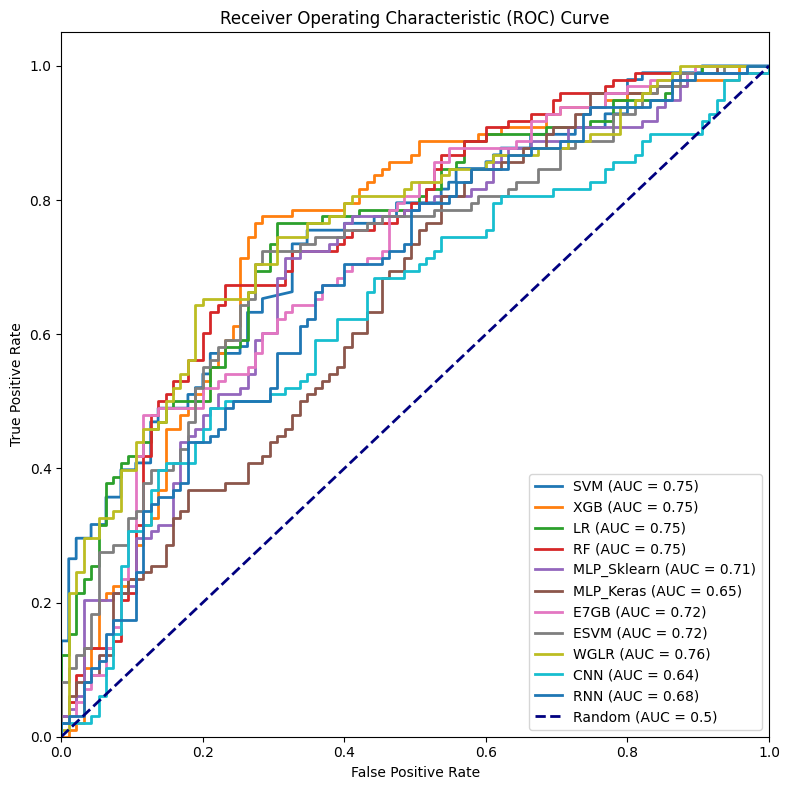

In [26]:
import pandas as pd
models_single = ['SVM', 'XGB', 'LR', 'RF']
models_mul = ['MLP_Sklearn', 'MLP_Keras', 'E7GB', 'ESVM', 'WGLR']
models_network = ['CNN', 'RNN']
models = models_single + models_mul + models_network

directory_result = '/kaggle/working/'
y_test = pd.read_csv("/kaggle/working/cogload/Experiment/SBS/y_test.csv").values
def combine_and_save(files, output_path, models, y_test):
    # Đọc và kết hợp các tệp CSV
    dataframes = [pd.read_csv(file) for file in files]
    combined = pd.concat(dataframes, ignore_index=True)
    combined.to_csv(output_path, index=False)
    # Vẽ biểu đồ ROC
    draw_ROC_models_read_file(models, y_test, path=output_path)

input_files = [
    '/kaggle/working/cogload/Experiment/SBS/SMA1/None/result.csv',
    '/kaggle/working/cogload/Experiment/SBS/SMA1/None/results_network_model (1).csv'
]
output_file = directory_result + 'results'
combine_and_save(input_files, output_file, models, y_test)

In [13]:
pd.read_csv('/kaggle/working/results')

,Model,Best Column,Shape,Accuracy,F1 Score,Precision,Recall,Confusion Matrix,Y Probs,best_model
0,SVM,"Index(['temp_diff', 'temp_q75', 'temp_qdev', '...",30.0,0.7046632124352331,0.721951,0.6915887850467289,0.7551020408163265,"[[62, 33], [24, 74]]","[0.6857149220462011, 0.2230563569561221, 0.513...",NaN
1,XGB,"Index(['temp_diff', 'hr_mean', 'hr_diff', 'hr_...",18.0,0.7357512953367875,0.741117,0.7373737373737373,0.7448979591836735,"[[69, 26], [25, 73]]","[0.9688996076583862, 0.13164933025836945, 0.71...",NaN
2,LR,"Index(['temp_skew', 'temp_q75', 'temp_qdev', '...",17.0,0.7305699481865285,0.742574,0.7211538461538461,0.7653061224489796,"[[66, 29], [23, 75]]","[0.6599837695122114, 0.19619285784312787, 0.58...",NaN
3,RF,"Index(['temp_mean', 'temp_skew', 'temp_q25', '...",24.0,0.7202072538860104,0.709677,0.75,0.673469387755102,"[[73, 22], [32, 66]]","[0.7206815392391483, 0.2659618515254965, 0.604...",NaN
4,MLP_Sklearn,"Index(['gsr_skew', 'gsr_q75', 'rr_std', 'rr_ku...",25.0,0.694300518134715,0.706468,0.6893203883495146,0.7244897959183674,"[[63, 32], [27, 71]]","[0.5415002724179102, 0.48130094125885, 0.51506...",NaN
5,MLP_Keras,"Index(['temp_kurtosis', 'gsr_kurtosis', 'gsr_m...",11.0,0.5751295336787565,0.544444,0.5975609756097561,0.5,"[[62, 33], [49, 49]]","[0.7745715379714966, 0.21868036687374115, 0.36...",NaN
6,E7GB,"Index(['temp_kurtosis', 'hr_mean', 'hr_q75', '...",9.0,0.6787564766839378,0.602564,0.8103448275862069,0.4795918367346938,"[[84, 11], [51, 47]]","[0.5836167870510542, 0.25279278995674137, 0.50...",NaN
7,WGLR,"Index(['temp_mean', 'temp_kurtosis', 'temp_q75...",11.0,0.7150259067357513,0.715026,0.7263157894736842,0.7040816326530612,"[[69, 26], [29, 69]]","[0.652653443056711, 0.4919346931568503, 0.6105...",NaN
8,ESVM,"Index(['temp_mean', 'temp_kurtosis', 'temp_dif...",30.0,0.7150259067357513,0.723618,0.7128712871287128,0.7346938775510204,"[[66, 29], [26, 72]]","[0.5048796657818987, 0.4947742361547819, 0.502...",NaN
9,CNN,NaN,NaN,0.6010362694300518 +- 0.04317163563232915,0.616915,[0.6019417475728155],[0.6326530612244898],"[[[54, 41], [36, 62]]]","[array([[0.5999716 ],\n [0.44703835],\n ...",Just one param in this model


###### 